In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('speakers_all.csv')
df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [3]:
path='recordings/recordings/'
df = df[df['file_missing?'] != True]
df.shape

(2138, 12)

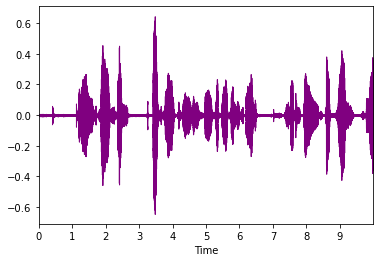

In [4]:
filename='english385.mp3' 
y,sr=librosa.load(path+str(filename),duration=10.0)
librosa.display.waveplot(y,sr=sr, x_axis='time', color='purple',offset=0.0)

In [5]:
y, sr = librosa.load('recordings/recordings/english381.mp3', offset=1.0, duration=10.0, sr=22050)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 431)

In [6]:
y, sr = librosa.load('recordings/recordings/dutch3.mp3', duration=10.0)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 431)

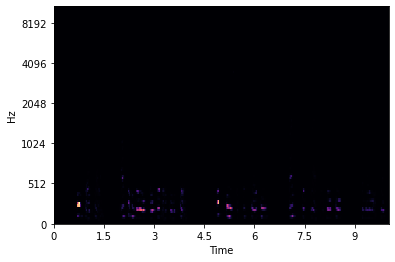

In [7]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [8]:
y, sr = librosa.load('recordings/recordings/english385.mp3', duration=10.0)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 431)

In [9]:
import numpy as np
from tqdm import tqdm

D = [] # Dataset

for index_num,row in tqdm(df.iterrows()):
    file_name = 'recordings/recordings/' + str(row["filename"]) + '.mp3'
    y, sr = librosa.load(file_name, duration=10.0)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 431): continue
    D.append( (ps, row["sex"]) )

2138it [21:40,  1.64it/s]


In [10]:
print("Number of samples: ", len(D))

Number of samples:  2138


In [11]:
dataset = D
random.shuffle(dataset)

train = dataset[:2000]
test = dataset[2000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 431, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 431, 1) ) for x in X_test])

In [12]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
#y=to_categorical(labelencoder.fit_transform(y))
#y
y_train = np.array(to_categorical(labelencoder.fit_transform(y_train)))
y_test = np.array(to_categorical(labelencoder.fit_transform(y_test)))

In [14]:
model = Sequential()
input_shape=(128, 431, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 124, 427, 24)      624       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 213, 24)       0         
_________________________________________________________________
activation_5 (Activation)    (None, 31, 213, 24)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 209, 48)       28848     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 104, 48)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 6, 104, 48)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 100, 48)       

In [16]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=32,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
63/63 [==============================] - 45s 690ms/step - loss: 0.6603 - accuracy: 0.7207 - val_loss: 0.5798 - val_accuracy: 0.7826
Epoch 2/12
63/63 [==============================] - 49s 773ms/step - loss: 0.3301 - accuracy: 0.8709 - val_loss: 0.1768 - val_accuracy: 0.9565
Epoch 3/12
63/63 [==============================] - 49s 772ms/step - loss: 0.2353 - accuracy: 0.9180 - val_loss: 0.1503 - val_accuracy: 0.9420
Epoch 4/12
63/63 [==============================] - 52s 831ms/step - loss: 0.1631 - accuracy: 0.9556 - val_loss: 0.2042 - val_accuracy: 0.8986
Epoch 5/12
63/63 [==============================] - 56s 894ms/step - loss: 0.1623 - accuracy: 0.9551 - val_loss: 0.1858 - val_accuracy: 0.9493
Epoch 6/12
63/63 [==============================] - 56s 883ms/step - loss: 0.0629 - accuracy: 0.9800 - val_loss: 0.1669 - val_accuracy: 0.9493
Epoch 7/12
63/63 [==============================] - 56s 886ms/step - loss: 0.0805 - accuracy: 0.9727 - val_loss: 0.1004 - val_accuracy: 0.9638

In [17]:
model.predict_classes(X_test)

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0], dtype=int64)

In [38]:
file_name = "recordings/recordings/english381.mp3"
y, sr = librosa.load(file_name, duration=10.0)  
ps = librosa.feature.melspectrogram(y=y, sr=sr)
d=[]
d.append( (ps, "null") )

x, y = zip(*d)
x = np.array([xi.reshape( (128, 431, 1) ) for xi in x])

predict = model.predict_classes(x)
prediction_class = labelencoder.inverse_transform(predict)
prediction_class

array(['male'], dtype='<U6')